In [54]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif


In [55]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
3,1,28,6,5.9,4,30,8,2,140/90,85,3000,2
4,1,28,6,5.9,4,30,8,2,140/90,85,3000,2
5,1,28,9,5.9,4,30,8,2,140/90,85,3000,1
6,1,29,10,6.3,6,40,7,2,140/90,82,3500,1
16,0,29,5,6.5,5,40,7,1,132/87,80,4000,2


In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Drop Person ID if exists
df.drop(columns=['Person ID'], errors='ignore', inplace=True)

# Split Blood Pressure into Systolic and Diastolic
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
df[['Systolic_BP', 'Diastolic_BP']] = df[['Systolic_BP', 'Diastolic_BP']].apply(pd.to_numeric, errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)


# Encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Occupation'] = le.fit_transform(df['Occupation'])
df['BMI Category'] = le.fit_transform(df['BMI Category'])

# Map Sleep Disorder to numerical values
sleep_disorder_mapping = {'None': 0, 'Insomnia': 1, 'Sleep Apnea': 2}  
df['Sleep Disorder'] = df['Sleep Disorder'].map(sleep_disorder_mapping)

# Drop rows with missing target values
df.dropna(subset=['Sleep Disorder'], inplace=True)
df['Sleep Disorder'] = df['Sleep Disorder'].astype(int)

# Define Features and Target
X = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

# One-hot encode categorical features
categorical_features = ['Gender', 'Occupation', 'BMI Category']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Only Numerical Features)
numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_features] = X_train[numerical_features].astype(float)
X_test[numerical_features] = X_test[numerical_features].astype(float)

X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 3 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   155 non-null    int32  
 1   Age                      155 non-null    int64  
 2   Occupation               155 non-null    int32  
 3   Sleep Duration           155 non-null    float64
 4   Quality of Sleep         155 non-null    int64  
 5   Physical Activity Level  155 non-null    int64  
 6   Stress Level             155 non-null    int64  
 7   BMI Category             155 non-null    int32  
 8   Heart Rate               155 non-null    int64  
 9   Daily Steps              155 non-null    int64  
 10  Sleep Disorder           155 non-null    int32  
 11  Systolic_BP              155 non-null    int64  
 12  Diastolic_BP             155 non-null    int64  
dtypes: float64(1), int32(4), int64(8)
memory usage: 14.5 KB
None

First 5 r

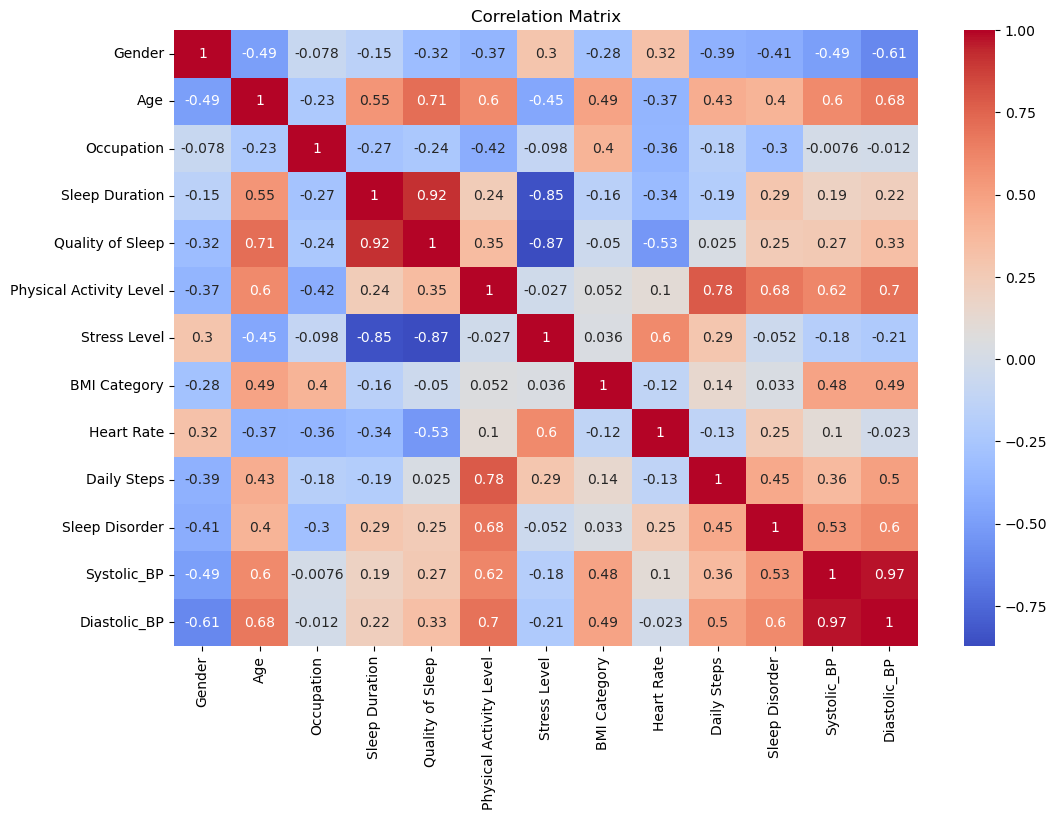

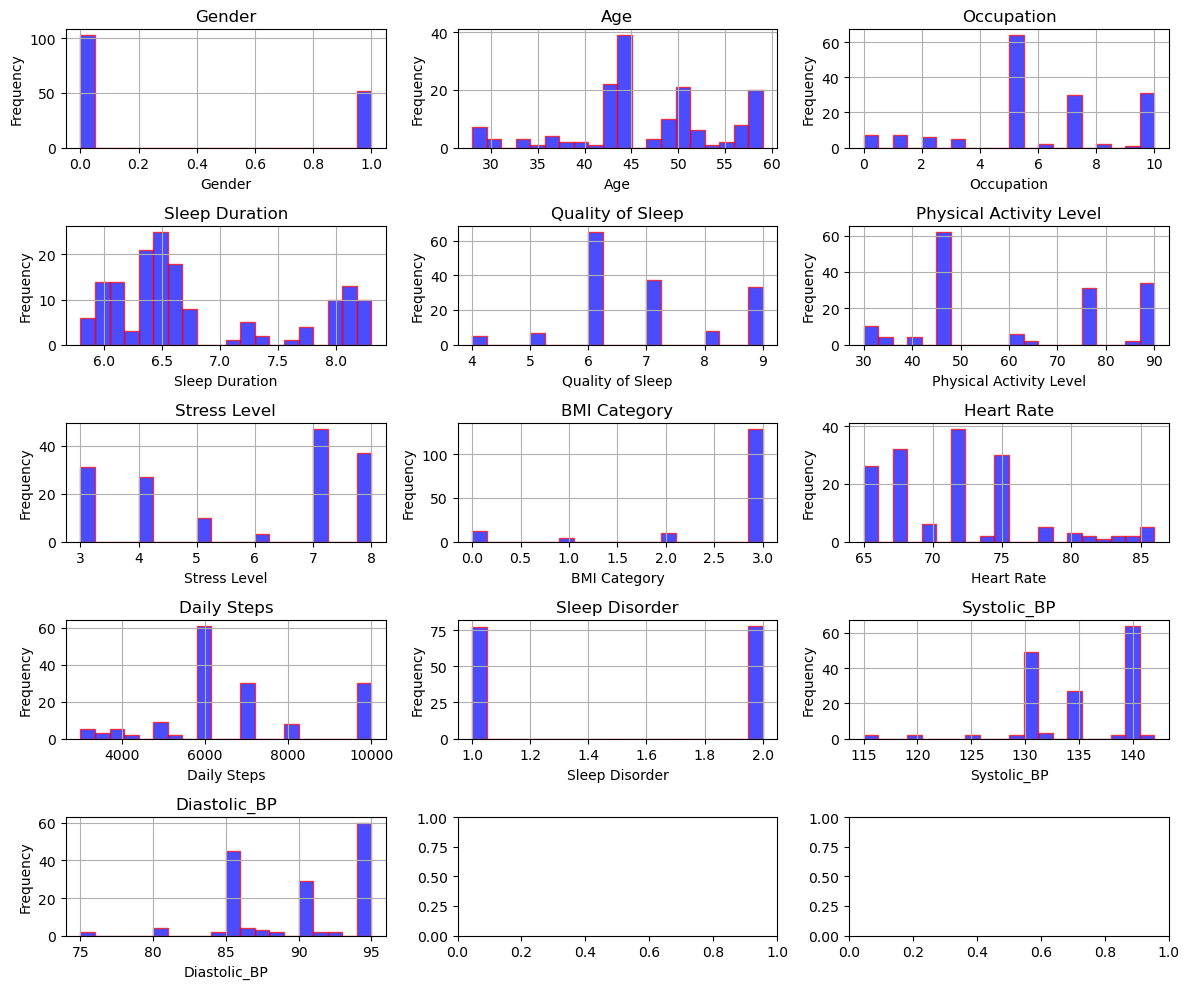

In [86]:
# Dataset Summary
print("Dataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nTarget Distribution:")
print(df['Sleep Disorder'].value_counts())

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 10))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    df[col].hist(ax=axes[i], bins=20, alpha=0.7, color='blue', edgecolor='red')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [88]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)

            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self._sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_pred]

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Train and evaluate custom model
custom_model = CustomLogisticRegression()
custom_model.fit(X_train[numerical_features], y_train)
custom_pred = custom_model.predict(X_test[numerical_features])

print("\nCustom Logistic Regression Accuracy:", accuracy_score(y_test, custom_pred))



Custom Logistic Regression Accuracy: 0.45161290322580644


In [90]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train & Evaluate Each Model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)


Logistic Regression Accuracy: 0.8065
Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.79      0.79        14
           2       0.82      0.82      0.82        17

    accuracy                           0.81        31
   macro avg       0.80      0.80      0.80        31
weighted avg       0.81      0.81      0.81        31

--------------------------------------------------
Random Forest Accuracy: 0.8387
Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.86      0.83        14
           2       0.88      0.82      0.85        17

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31

--------------------------------------------------


In [64]:
# Logistic Regression Hyperparameter Tuning
param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_search_lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_lr, cv=5)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_
print("\nBest Logistic Regression Accuracy:", accuracy_score(y_test, best_lr.predict(X_test)))

# Random Forest Hyperparameter Tuning
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("\nBest Random Forest Accuracy:", accuracy_score(y_test, best_rf.predict(X_test)))



Best Logistic Regression Accuracy: 0.7741935483870968

Best Random Forest Accuracy: 0.8387096774193549


In [92]:
selector = SelectKBest(f_classif, k=8)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = X_train.columns[selector.get_support()]
print("\nSelected Features:", list(selected_features))



Selected Features: ['Age', 'Physical Activity Level', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP', 'Gender_1', 'Occupation_5', 'Occupation_7']



Final Model Accuracy: 0.8709677419354839

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.86      0.86        14
           2       0.88      0.88      0.88        17

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31



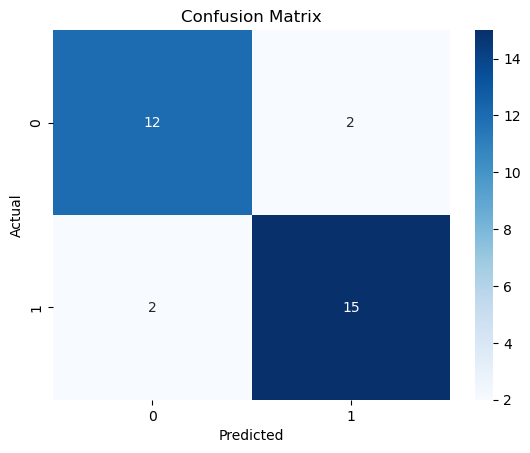

In [94]:
# Train Final Random Forest Model
final_rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
final_rf.fit(X_train[selected_features], y_train)
final_pred = final_rf.predict(X_test[selected_features])

print("\nFinal Model Accuracy:", accuracy_score(y_test, final_pred))
print("\nClassification Report:")
print(classification_report(y_test, final_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [67]:
print("\nFinal Report Summary:")
print(f"Custom Logistic Regression Accuracy: {accuracy_score(y_test, custom_pred):.4f}")
print(f"Best Logistic Regression Accuracy: {accuracy_score(y_test, best_lr.predict(X_test)):.4f}")
print(f"Best Random Forest Accuracy: {accuracy_score(y_test, best_rf.predict(X_test)):.4f}")
print(f"Final Model Accuracy (Tuned Random Forest): {accuracy_score(y_test, final_pred):.4f}")



Final Report Summary:
Custom Logistic Regression Accuracy: 0.4516
Best Logistic Regression Accuracy: 0.7742
Best Random Forest Accuracy: 0.8387
Final Model Accuracy (Tuned Random Forest): 0.8710
